In [3]:
# Try and load the KA data with xarray.open_mfdataset
import xarray as xr
import os
from datetime import datetime, date
import re

source_folder = r"..\data\raw\ka_36ghz\Ascending"

In [4]:
# Processing stages:

def apply_scaling(ds: xr.Dataset) -> xr.Dataset:
    """
    Apply scaling factors to data variables in an Xarray Dataset based on the "SCALE FACTOR" attribute.

    :param xarray_dataset: The input Xarray Dataset.
    :return: A new Xarray Dataset with scaled variables.
    """
    
    for dvar in ds.data_vars:
        if "SCALE FACTOR" in ds[dvar].attrs.keys():
            scale_factor = ds[dvar].attrs["SCALE FACTOR"]
            if scale_factor != 1:
                ds[dvar] *= scale_factor
                ds[dvar].attrs["SCALE FACTOR"] = 1  # Update the attribute

    return ds

def recover_dates(folder_path: str, dates_regex: str = r"_(\d{4})_(\d{2})_(\d{2})") -> list[date]:
    """Helper, returns a list of dates parsing the files within the folder"""

    dates = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):

            year, month, day = [
                int(number) for number in re.findall(dates_regex, file)[0]
            ]
            dates.append(date(year, month, day))

    return dates

def get_day_of_the_year(dates: list[date]) -> list[int]:
    """Get the day of the year"""
    days = [d.timetuple().tm_yday for d in dates]

    return days

In [5]:
from functools import partial
def ka_preprocess(ds:xr.Dataset)-> xr.Dataset:
    """ Wrapper"""
    ds = apply_scaling(ds)

    return ds

_ka_preprocess = partial(ka_preprocess)

In [6]:
# Recover the dates using regex function
dates = recover_dates(source_folder, dates_regex= r"_(\d{4})(\d{2})(\d{2})_")
day_numbers = get_day_of_the_year(dates)


In [7]:
ds_ascending = xr.open_mfdataset(
        paths= os.path.join(source_folder,"*.h5"),
        concat_dim="day_number",
        preprocess= _ka_preprocess,
        combine="nested",
    )
ds_ascending["day_number"] = day_numbers
ds_ascending["day_number"].attrs ={
    "Description" : f"Day of the year {dates[0].year}",
}
ds_ascending

<xarray.Dataset> Size: 4GB
Dimensions:                     (lon: 1388, lat: 584, day_number: 365)
Coordinates:
  * lon                         (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 2kB -83.52 -81.98 ... 81.98 83.52
  * day_number                  (day_number) int32 1kB 1 2 3 4 ... 363 364 365
Data variables:
    Brightness Temperature (H)  (day_number, lat, lon) float32 1GB dask.array<chunksize=(1, 584, 1388), meta=np.ndarray>
    Brightness Temperature (V)  (day_number, lat, lon) float32 1GB dask.array<chunksize=(1, 584, 1388), meta=np.ndarray>
    Time Information            (day_number, lat, lon) float32 1GB dask.array<chunksize=(1, 584, 1388), meta=np.ndarray>
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

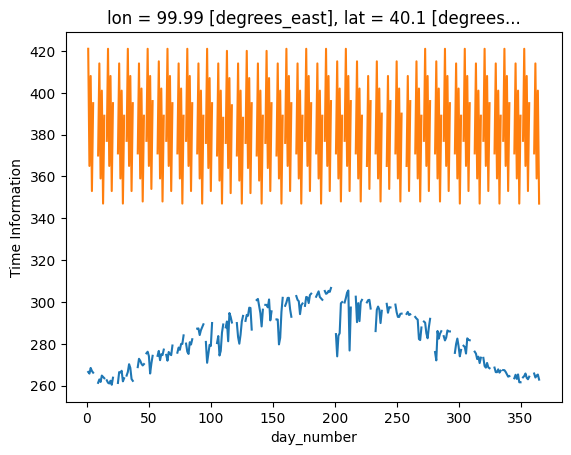

In [23]:
# Time of observation is captured here, we can retrieve the exact time of each observation by adding this dimension
# to the date

ds_ascending.sel(lat = 40, lon = 100, method="nearest")["Brightness Temperature (V)"].plot() 

# This plot selects data from the day_number and at the minute:
ds_ascending.sel(lat = 40, lon = 100, method="nearest")["Time Information"].plot()

In [24]:
# We can retrieve the exact time of each observation and match it to the insitu data as long as we have hourly or lower retrieval times

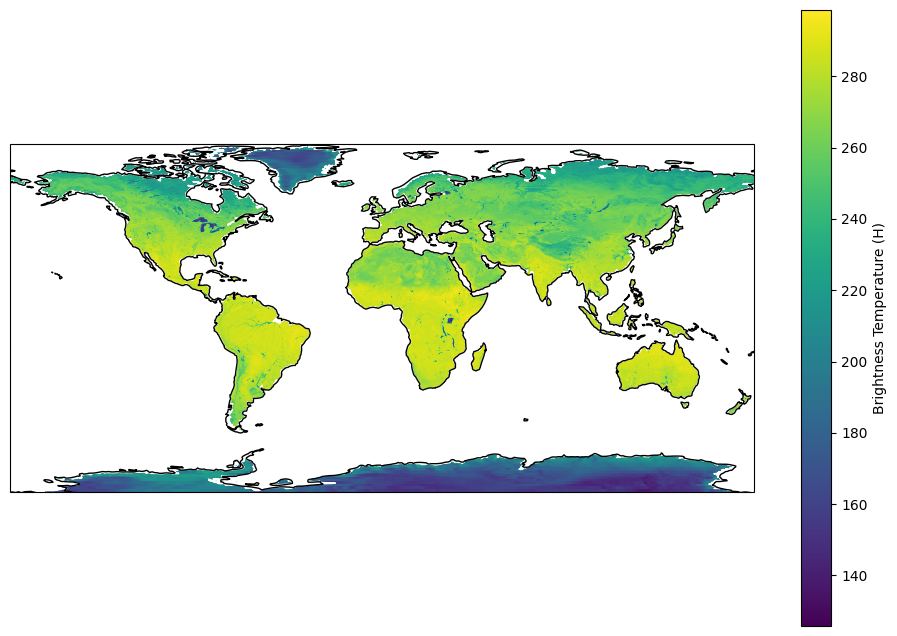

In [44]:
import cartopy as cart
import matplotlib.pyplot as plt
data = ds_ascending.mean(dim="day_number")["Brightness Temperature (H)"]
fig, ax = plt.subplots(1,1,subplot_kw={"projection":cart.crs.PlateCarree()}, figsize = (12,8))


# Land mask
land_mask = cart.feature.NaturalEarthFeature('physical', 'ocean', '10m',
                                             edgecolor='face',
                                             facecolor="white")
ax.add_feature(land_mask)

data.plot(ax=ax)
ax.coastlines()

plt.show()
